# Grid-based sampling

This notebook contains a recipe for using vtkImageData to create a grid structure, and then projects the mesh onto the grid.

This results in an even sampling across surfaces which fall neatly into the grid, but where the meshes do not intersect the grid, they remain unsampled.

This is a bit of a shame because it results in very evenly spaced points across the surface, but any attempt to refine this to interpolate nearby grid cells will probably not be worthwhile as the cloud will have the relative positions of different objects be shifted about in-line with the resolution, which is very problematic in terms of producing high-fidelity clouds.

In [5]:
import vtk
import numpy as np

def create_image_data(bounds, spacing):
    """
    Creates a vtkImageData object with uniformly spaced points within specified bounds.

    Args:
        bounds (tuple): Bounds in the form (xmin, xmax, ymin, ymax, zmin, zmax).
        spacing (tuple): Spacing between points in each dimension (x_spacing, y_spacing, z_spacing).

    Returns:
        vtk.vtkImageData: A vtkImageData object with uniformly spaced points.
    """
    # Create a vtkImageData object
    image_data = vtk.vtkImageData()

    # Define the spacing (distance between points in each dimension)
    x_spacing, y_spacing, z_spacing = spacing

    # Set the bounds of the image data
    xmin, xmax, ymin, ymax, zmin, zmax = bounds

    # Calculate the dimensions based on spacing
    dim_x = int((xmax - xmin) / x_spacing) + 1
    dim_y = int((ymax - ymin) / y_spacing) + 1
    dim_z = int((zmax - zmin) / z_spacing) + 1

    # Set the dimensions and spacing of the image data
    image_data.SetDimensions(dim_x, dim_y, dim_z)
    image_data.SetSpacing(x_spacing, y_spacing, z_spacing)
    image_data.SetOrigin(xmin, ymin, zmin)

    return image_data


def project_image_data_to_mesh(image_data, mesh):
    """
    Projects the points of vtkImageData onto the surface of a vtkPolyData mesh.

    Args:
        image_data (vtk.vtkImageData): The input image data with uniformly spaced points.
        mesh (vtk.vtkPolyData): The target mesh for projection.

    Returns:
        vtk.vtkPolyData: A vtkPolyData object containing the projected points.
    """
    # Create a probe filter to project the grid points onto the mesh surface
    probe_filter = vtk.vtkProbeFilter()
    probe_filter.SetInputData(image_data)
    probe_filter.SetSourceData(mesh)
    probe_filter.Update()

    # Convert the output of the probe filter to vtkPolyData using vtkThresholdPoints
    threshold_points = vtk.vtkThresholdPoints()
    threshold_points.SetInputData(probe_filter.GetOutput())
    threshold_points.ThresholdByUpper(1.0)  # Include all points
    threshold_points.Update()

    # Get the output as vtkPolyData
    projected_points_polydata = threshold_points.GetOutput()

    return projected_points_polydata


def visualize_vtk_object(vtk_object, window_name="VTK Object Viewer"):
    """
    Visualizes a VTK object (vtkPolyData) in a VTK render window.

    Args:
        vtk_object (vtk.vtkPolyData): The VTK object to visualize.
        window_name (str): The title of the VTK render window.
    """
    # Create a mapper and actor for the vtk object
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputData(vtk_object)

    actor = vtk.vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetPointSize(3)  # Increase point size for better visibility
    actor.GetProperty().SetColor(1.0, 1.0, 1.0)  # Set point color to white for better contrast

    # Create a renderer and render window
    renderer = vtk.vtkRenderer()
    renderer.AddActor(actor)
    renderer.SetBackground(0.1, 0.2, 0.4)  # Set background color (dark blue)

    render_window = vtk.vtkRenderWindow()
    render_window.AddRenderer(renderer)
    render_window.SetSize(800, 600)  # Set the window size
    render_window.SetWindowName(window_name)

    # Adjust camera to fit all points
    renderer.ResetCamera()
    renderer.GetActiveCamera().Zoom(1.5)  # Adjust zoom to fit the points better

    # Create a render window interactor
    render_window_interactor = vtk.vtkRenderWindowInteractor()
    render_window_interactor.SetRenderWindow(render_window)

    # Add an interactor style (optional, provides better mouse interaction)
    style = vtk.vtkInteractorStyleTrackballCamera()
    render_window_interactor.SetInteractorStyle(style)

    # Initialize and start the rendering loop
    render_window.Render()
    render_window_interactor.Initialize()
    render_window_interactor.Start()


# Load the mesh file using VTK
mesh_file = '/home/sogilvy/para_test/meshes/extracted/library/1_wall.ply'  # Replace with your mesh file path

# Read the mesh using VTK
reader = vtk.vtkPLYReader()
reader.SetFileName(mesh_file)
reader.Update()
mesh = reader.GetOutput()

# Define the bounds and spacing for vtkImageData
bounds = mesh.GetBounds()  # Use the bounds of the mesh
spacing = (0.05, 0.05, 0.05)  # Example: uniform spacing of 0.1 units in each dimension

# Step 1: Create vtkImageData with uniform spacing
image_data = create_image_data(bounds, spacing)

# Step 2: Project the vtkImageData points onto the mesh surface
projected_points_polydata = project_image_data_to_mesh(image_data, mesh)

# Visualize the projected points on the mesh
visualize_vtk_object(projected_points_polydata)


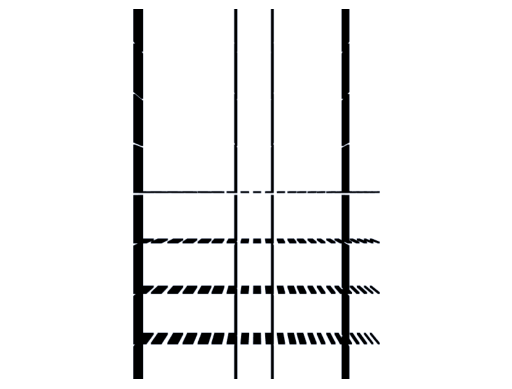

In [6]:
import vtk
from vtk.util.numpy_support import vtk_to_numpy
import matplotlib.pyplot as plt

def capture_vtk_rendering_as_image(vtk_object):
    """
    Renders a vtkPolyData object and captures it as an image for display in a Jupyter notebook.
    
    Args:
        vtk_object (vtk.vtkPolyData): The VTK object to render.
        
    Returns:
        numpy.ndarray: Image array suitable for display with matplotlib.
    """
    # Create a mapper and actor for the vtk object
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputData(vtk_object)

    actor = vtk.vtkActor()
    actor.SetMapper(mapper)
    actor.GetProperty().SetPointSize(3)  # Increase point size for better visibility
    actor.GetProperty().SetColor(1.0, 1.0, 1.0)  # Set point color to white for better contrast

    # Create a renderer and render window
    renderer = vtk.vtkRenderer()
    renderer.AddActor(actor)
    renderer.SetBackground(0.1, 0.2, 0.4)  # Set background color (dark blue)

    render_window = vtk.vtkRenderWindow()
    render_window.AddRenderer(renderer)
    render_window.SetSize(800, 600)  # Set the window size

    # Adjust camera to fit all points
    renderer.ResetCamera()
    renderer.GetActiveCamera().Zoom(1.5)  # Adjust zoom to fit the points better

    # Capture the rendering to an image
    window_to_image_filter = vtk.vtkWindowToImageFilter()
    window_to_image_filter.SetInput(render_window)
    window_to_image_filter.SetScale(1)  # Image size scale
    window_to_image_filter.SetInputBufferTypeToRGBA()  # Ensure we get all colors including alpha
    window_to_image_filter.ReadFrontBufferOff()  # Read from the back buffer
    window_to_image_filter.Update()

    # Convert the captured image to a format suitable for matplotlib
    vtk_image = window_to_image_filter.GetOutput()
    width, height, _ = vtk_image.GetDimensions()
    vtk_array = vtk_to_numpy(vtk_image.GetPointData().GetScalars())
    vtk_array = vtk_array.reshape(height, width, 4)
    
    # Reverse the vertical direction because VTK's origin is bottom-left
    return vtk_array[::-1]

# Run the function to capture the rendering
image_array = capture_vtk_rendering_as_image(projected_points_polydata)

# Display the image using matplotlib
plt.imshow(image_array)
plt.axis('off')  # Hide axis
plt.show()
